# Variational Quantum Eigensolver (VQE) Algorithm

The Variational Quantum Eigensolver (VQE) is a hybrid quantum-classical algorithm designed to find the ground state energy of a molecule or a Hamiltonian system. It's one of the most promising algorithms for near-term quantum computers due to its ability to work with noisy, limited-resource quantum hardware.

## How VQE Works

1. **Prepare a parameterized quantum state**: Create a quantum circuit with adjustable parameters
2. **Measure the energy**: Use the quantum computer to measure the expectation value of the Hamiltonian
3. **Update parameters**: Use a classical optimizer to find parameters that minimize the energy
4. **Iterate**: Repeat until convergence

In this notebook, we'll implement VQE to find the ground state energy of a simple Hamiltonian using Qiskit 2.



In [4]:
# Import required libraries
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info import SparsePauliOp

# For visualization
import matplotlib.pyplot as plt
%matplotlib inline

## Creating a Hamiltonian

The Hamiltonian is the energy operator of our system. For this example, we'll use a simple 2-qubit Hamiltonian that represents the interactions in a toy molecular system. In Qiskit 2, we can represent this using `SparsePauliOp`.

In [5]:
# Define a simple 2-qubit Hamiltonian
# H = Z₀⊗I₁ + I₀⊗Z₁ + 0.5 X₀⊗X₁
# This represents a simplified Ising model

# Create the Hamiltonian using SparsePauliOp
hamiltonian = SparsePauliOp(
    ['ZI', 'IZ', 'XX'],  # Pauli strings
    [1.0, 1.0, 0.5]      # Coefficients
)

print("Hamiltonian:")
print(hamiltonian)

Hamiltonian:
SparsePauliOp(['ZI', 'IZ', 'XX'],
              coeffs=[1. +0.j, 1. +0.j, 0.5+0.j])


## Variational Form (Ansatz)

The ansatz is a parameterized quantum circuit that prepares a trial state. The goal is to find the parameters that minimize the energy. We'll use a simple ansatz with rotation gates and entangling operations.

In [6]:
# Create a parameterized ansatz with rotation gates and entanglement
def create_ansatz(parameters):
    """Create a parameterized quantum circuit.
    
    Args:
        parameters (list): List of 6 parameters for the circuit
    
    Returns:
        QuantumCircuit: The parameterized quantum circuit
    """
    qc = QuantumCircuit(2)
    
    # First layer of rotations
    qc.rx(parameters[0], 0)
    qc.ry(parameters[1], 0)
    qc.rx(parameters[2], 1)
    qc.ry(parameters[3], 1)
    
    # Entangling layer
    qc.cx(0, 1)
    
    # Second layer of rotations
    qc.rx(parameters[4], 0)
    qc.rx(parameters[5], 1)
    
    return qc

# Visualize the ansatz with some random parameters
initial_params = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
ansatz = create_ansatz(initial_params)
print("Sample ansatz circuit:")
print(ansatz.draw())

Sample ansatz circuit:
     ┌─────────┐┌─────────┐     ┌─────────┐
q_0: ┤ Rx(0.1) ├┤ Ry(0.2) ├──■──┤ Rx(0.5) ├
     ├─────────┤├─────────┤┌─┴─┐├─────────┤
q_1: ┤ Rx(0.3) ├┤ Ry(0.4) ├┤ X ├┤ Rx(0.6) ├
     └─────────┘└─────────┘└───┘└─────────┘


## Energy Calculation

For each set of parameters, we need to calculate the expectation value of the Hamiltonian. This is done by preparing the state defined by our ansatz and measuring the energy using our Hamiltonian.

In [8]:
# Function to calculate the expectation value of the Hamiltonian
def calculate_energy(parameters):
    """Calculate the expectation value of the Hamiltonian for given parameters.
    
    Args:
        parameters (list): Ansatz parameters
    
    Returns:
        float: Expected energy
    """
    # Create the ansatz circuit with current parameters
    qc = create_ansatz(parameters)
    
    # Configure the simulator to return the statevector
    simulator = AerSimulator(method='statevector')
    
    # Save the statevector state
    qc.save_statevector()
    
    # Run the circuit and get the statevector
    job = simulator.run(qc)
    result = job.result()
    
    # Get the statevector from the result
    state = result.get_statevector()
    
    # Calculate the expectation value of the Hamiltonian
    energy = state.expectation_value(hamiltonian).real
    
    return energy

# Test the energy calculation with initial parameters
energy = calculate_energy(initial_params)
print(f"Energy with initial parameters: {energy:.6f}")

Energy with initial parameters: 1.482304


## Classical Optimization

Now we'll use a classical optimizer to find the parameters that minimize the energy. We'll use the COBYLA optimizer from scipy, which is a gradient-free optimization method.

In [9]:
# Perform the optimization using scipy's minimize function
from scipy.optimize import minimize

# Function to minimize
def objective_function(parameters):
    return calculate_energy(parameters)

# Initial parameters
initial_params = np.random.random(6) * 2 * np.pi

# Keep track of energy values during optimization
energy_values = []

# Callback function to track optimization progress
def callback(params):
    energy = objective_function(params)
    energy_values.append(energy)
    if len(energy_values) % 5 == 0:  # Print every 5 iterations
        print(f"Iteration {len(energy_values)}: Energy = {energy:.6f}")

# Run the optimizer
print("Starting optimization...")
result = minimize(
    objective_function,
    initial_params,
    method='COBYLA',
    callback=callback,
    options={'maxiter': 100}
)

# Print results
print("\nOptimization complete!")
print(f"Final energy: {result.fun:.6f}")
print(f"Optimal parameters: {result.x}")

Starting optimization...
Iteration 5: Energy = -0.191608
Iteration 10: Energy = -0.529871
Iteration 15: Energy = -1.824972
Iteration 20: Energy = -1.897136
Iteration 25: Energy = -1.917181
Iteration 30: Energy = -2.044816
Iteration 35: Energy = -2.044973
Iteration 40: Energy = -2.056614
Iteration 45: Energy = -2.060697
Iteration 50: Energy = -2.060958
Iteration 55: Energy = -2.061336
Iteration 60: Energy = -2.061413
Iteration 65: Energy = -2.061514
Iteration 70: Energy = -2.061489
Iteration 75: Energy = -2.061540
Iteration 80: Energy = -2.061531
Iteration 85: Energy = -2.061551
Iteration 90: Energy = -2.061551
Iteration 95: Energy = -2.061551
Iteration 100: Energy = -2.061552

Optimization complete!
Final energy: -2.061553
Optimal parameters: [3.14141806 2.89651386 4.71260179 5.23372333 3.14166897 4.7118925 ]


## Results Visualization

Let's visualize the convergence of the energy during the optimization process.

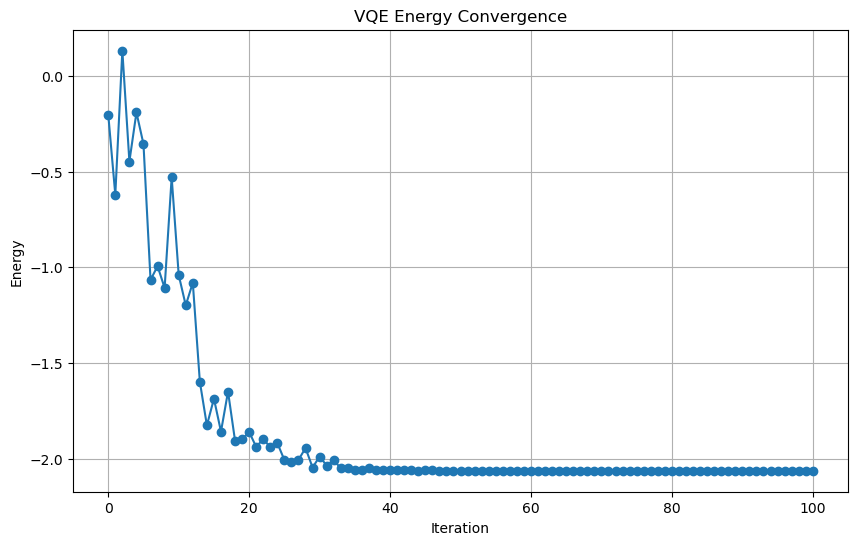

In [10]:
# Plot the energy convergence
plt.figure(figsize=(10, 6))
plt.plot(energy_values, 'o-')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('VQE Energy Convergence')
plt.grid(True)
plt.show()

## Final Optimized Circuit

Let's visualize the circuit with the optimized parameters and calculate the probabilities of measuring different states.

In [ ]:
# Create and display the final circuit with optimized parameters
final_circuit = create_ansatz(result.x)
print("Final optimized circuit:")
print(final_circuit.draw())

# Add measurements to get the state probabilities
final_circuit_with_measure = create_ansatz(result.x)
final_circuit_with_measure.measure_all()

# Run the circuit
simulator = AerSimulator()
result_counts = simulator.run(final_circuit_with_measure, shots=1000).result().get_counts()

# Display the results
print("\nState probabilities from 1000 measurements:")
for state, counts in result_counts.items():
    print(f"State |{state}>: {counts/1000:.4f} probability")

# Plot the histogram
plt.figure(figsize=(10, 6))
states = result_counts.keys()
probabilities = [result_counts[state]/1000 for state in states]
plt.bar(states, probabilities)
plt.xlabel('State')
plt.ylabel('Probability')
plt.title('Measurement Probabilities of the Ground State')
plt.ylim(0, 1)
plt.show()

## Conclusion

In this notebook, we've implemented the VQE algorithm to find the ground state energy of a simple 2-qubit Hamiltonian. The key steps included:

1. Defining a Hamiltonian representing our system
2. Creating a parameterized quantum circuit (ansatz)
3. Calculating the energy expectation value for a given set of parameters
4. Using classical optimization to find the parameters that minimize the energy
5. Analyzing and visualizing the results

VQE is particularly important for quantum chemistry applications, where it can be used to calculate molecular properties more efficiently than classical methods for complex molecules. As quantum hardware improves, VQE can be applied to increasingly complex systems.

## References

1. Peruzzo, A. et al. (2014). A variational eigenvalue solver on a photonic quantum processor. Nature Communications, 5, 4213.
2. [Qiskit Documentation on VQE](https://qiskit.org/documentation/tutorials/algorithms/03_vqe.html)
3. McArdle, S. et al. (2020). Quantum computational chemistry. Reviews of Modern Physics, 92(1), 015003.